In [1]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import numpy as np
import labrotation.file_handling as fh
import os
import pandas as pd
import labrotation.two_photon_session as tps
import datadoc_util
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime as dt

In [3]:
save_figs = False

In [4]:
env_dict = dict()
if not os.path.exists("./.env"):
    print(".env does not exist")
else:
    with open("./.env", "r") as f:
        for line in f.readlines():
            l = line.rstrip().split("=")
            env_dict[l[0]] = l[1]
print(env_dict.keys())

dict_keys(['DATA_DOCU_FOLDER', 'DOWNLOADS_FOLDER', 'LOG_FOLDER', 'MATLAB_2P_FOLDER', 'FLUO_LV_MATCHED_FOLDER', 'SERVER_SYMBOL'])


In [5]:
if "DATA_DOCU_FOLDER" in env_dict.keys():
    data_docu_folder = env_dict["DATA_DOCU_FOLDER"]
else:
    data_docu_folder = fh.open_dir("Open Data Documentation folder")
print(data_docu_folder)

C:\Data documentation


In [6]:
ddoc = datadoc_util.DataDocumentation(data_docu_folder)
ddoc.loadDataDoc()

In [7]:
df_colors = ddoc.getColorings()

In [8]:
dict_colors_mouse = df_colors[["mouse_id", "color"]].to_dict(orient="list")
dict_colors_mouse = dict(zip(dict_colors_mouse["mouse_id"], dict_colors_mouse["color"]))

In [9]:
ddoc.getSegmentsForUUID("04b8cfbfa1c347058bb139b4661edcf1")

,interval_type,frame_begin,frame_end
23,normal,1,4573
24,stimulation,4574,4652
25,sd_wave,4653,4709
26,sd_extinction,4710,5814
27,normal,5815,13483


In [10]:
event_traces_fpath = fh.open_file("Open .h5 file containing assembled traces for all seizures!")
print(event_traces_fpath)

C:\Data\assembled_traces_20231103-153723_ChR2.h5


In [11]:
traces_dict = dict()  
traces_meta_dict = dict()
# first keys are event uuids, inside the following dataset names:
# 'lfp_mov_t', 'lfp_mov_y', 'lfp_t', 'lfp_y', 'lv_dist', 'lv_rounds', 
# 'lv_running', 'lv_speed', 'lv_t_s', 'lv_totdist', 'mean_fluo'
with h5py.File(event_traces_fpath, "r") as hf:
    for uuid in hf.keys():
        session_dataset_dict = dict() 
        session_meta_dict = dict()
        for dataset_name in hf[uuid].keys():
            session_dataset_dict[dataset_name] = np.array(hf[uuid][dataset_name])
        for attr_name in hf[uuid].attrs:
            session_meta_dict[attr_name] = hf[uuid].attrs[attr_name]
        traces_dict[uuid] = session_dataset_dict.copy()
        traces_meta_dict[uuid] = session_meta_dict.copy()

In [12]:
exptype_wintype_id_dict = {}   # keys: experiment_type, window_type, mouse_id, value: [uuid1, uuid2, ...]
for uuid in traces_meta_dict.keys():
    exp_type = traces_meta_dict[uuid]["exp_type"]
    win_type = traces_meta_dict[uuid]["window_type"]
    mouse_id = traces_meta_dict[uuid]["mouse_id"]
    if exp_type not in exptype_wintype_id_dict.keys():
        exptype_wintype_id_dict[exp_type] = dict()
    else:
        if win_type not in exptype_wintype_id_dict[exp_type].keys():
            exptype_wintype_id_dict[exp_type][win_type] = dict()
        else:
            if mouse_id not in exptype_wintype_id_dict[exp_type][win_type].keys():
                exptype_wintype_id_dict[exp_type][win_type][mouse_id] = []  # list of uuids
            exptype_wintype_id_dict[exp_type][win_type][mouse_id].append(uuid)
                
#traces_meta_dict

In [13]:
exptype_wintype_id_dict.keys()

dict_keys(['chr2_sd', 'chr2_ctl', 'chr2_lfpsz_sd', 'chr2_szsd'])

In [14]:
df_colors

,mouse_id,color,red,green,blue
0,T301,#97d0f7,151,208,247
1,T329,#3ea3e9,62,163,233
2,T333,#0576c5,5,118,197
3,T391,#9ee895,158,232,149
4,T396,#60cf44,96,207,68
5,T534,#399026,57,144,38
6,T352,#003e69,0,62,105
7,T430,#EAD1D5,234,209,213
8,T452,#CF98A0,207,152,160
9,T413,#B45F6B,180,95,107


186b6362f4304104b35bdd072632eef5: 4494, T370, chr2_ctl
c85d269be9be47a695ed0b21a8cbdc21: 4610, T370, chr2_ctl
d5a2287a5fad4cbc8dbf22aaa7d84c55: 4494, T370, chr2_ctl
e1daa5373d0740afb87178d132250a9b: 6741, T370, chr2_ctl


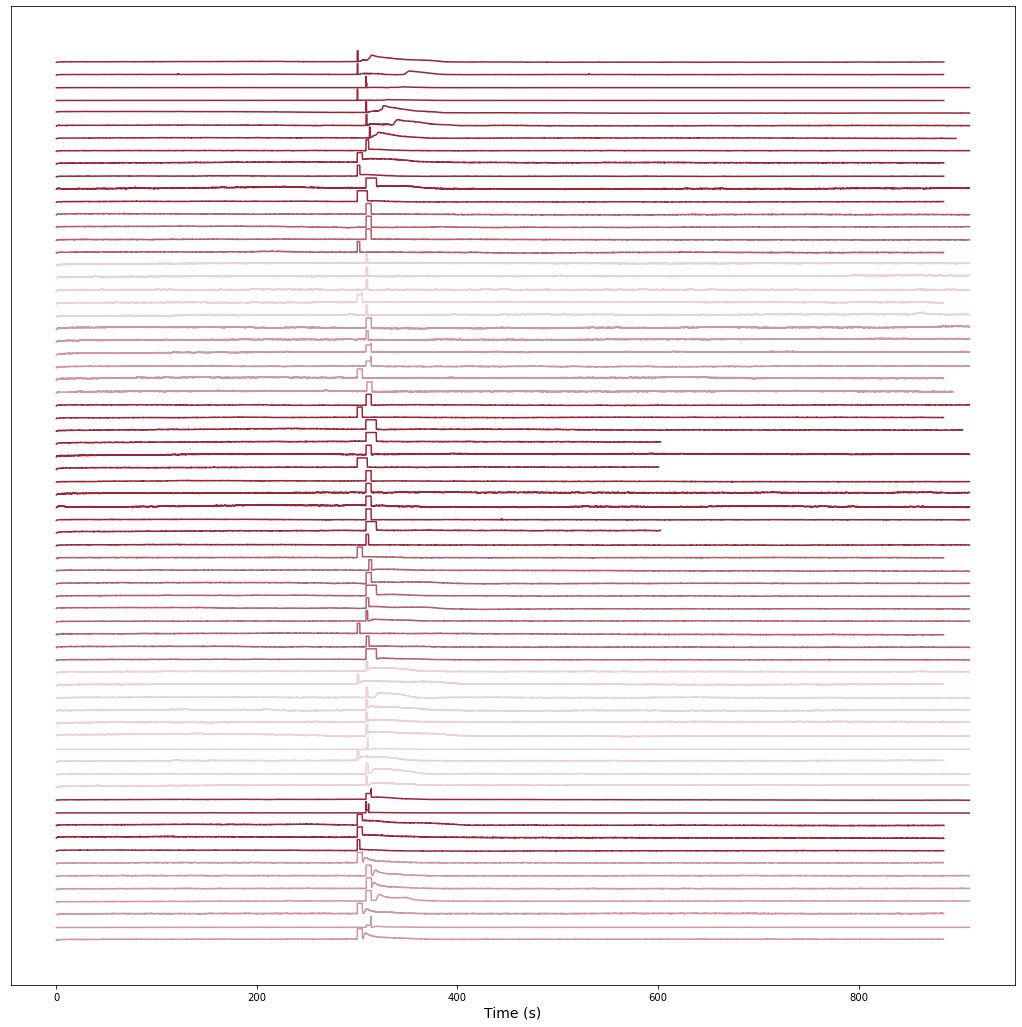

In [15]:
AMPLITUDE = 100.0
offset = 0
fig = plt.figure(figsize=(18,18))
mouse_ids = traces_dict.keys()
prev_range = 0.0

for exp_type in exptype_wintype_id_dict.keys():
    for win_type in exptype_wintype_id_dict[exp_type].keys():
        for mouse_id in exptype_wintype_id_dict[exp_type][win_type].keys():
            for event_uuid in exptype_wintype_id_dict[exp_type][win_type][mouse_id]:
                df_segments = ddoc.getSegmentsForUUID(event_uuid)
                i_frame_stim_begin = df_segments[df_segments["interval_type"] == "stimulation"].frame_begin.iloc[0] - 1
                i_frame_stim_end = df_segments[df_segments["interval_type"] == "stimulation"].frame_end.iloc[0] - 1  # in 1 indexing, inclusive
                
                nik_trace = traces_dict[event_uuid]["mean_fluo"]
                
                nik_trace[i_frame_stim_begin:i_frame_stim_end] = 1.2*max(nik_trace[i_frame_stim_end+1:])  # reduce stim amplitude
                
                min_nik = min(nik_trace)
                max_nik = max(nik_trace)
                
                t = traces_dict[event_uuid]["lv_t_s"]
                
                color = df_colors[df_colors["mouse_id"] == mouse_id].color.iloc[0]
                plt.plot(t, AMPLITUDE*(nik_trace- min_nik)/(max_nik - min_nik)+offset, color=color)
                offset+=1.1*AMPLITUDE
                if (len(traces_dict[event_uuid]["mean_fluo"]) != 13483):
                    print(f'{event_uuid}: {len(traces_dict[event_uuid]["mean_fluo"])}, {mouse_id}, {exp_type}')





#plt.axis("off")
plt.yticks([])
plt.xlabel("Time (s)", fontsize=14)
#plt.xlim((300, 460))  # 250, 500
if save_figs:
    out_fpath = f"D:\\Downloads\\traces_normalized_{get_datetime_for_fname()}{file_format}"
    plt.savefig(out_fpath,bbox_inches='tight', dpi=300)
    print(f"Saved as {out_fpath}")
plt.show()

### Plot Nik + Loco

In [16]:
def plotNikLoco(exp_type):
    AMPLITUDE = 100.0
    offset = 0
    fig = plt.figure(figsize=(18,24))
    mouse_ids = traces_dict.keys()
    prev_range = 0.0
    for win_type in exptype_wintype_id_dict[exp_type].keys():
        for mouse_id in exptype_wintype_id_dict[exp_type][win_type].keys():
            for event_uuid in exptype_wintype_id_dict[exp_type][win_type][mouse_id]:
                df_segments = ddoc.getSegmentsForUUID(event_uuid)
                i_frame_stim_begin = df_segments[df_segments["interval_type"] == "stimulation"].frame_begin.iloc[0] - 1
                i_frame_stim_end = df_segments[df_segments["interval_type"] == "stimulation"].frame_end.iloc[0] - 1  # in 1 indexing, inclusive

                nik_trace = traces_dict[event_uuid]["mean_fluo"]

                nik_trace[i_frame_stim_begin:i_frame_stim_end] = 1.2*max(nik_trace[i_frame_stim_end+1:])  # reduce stim amplitude

                min_nik = min(nik_trace)
                max_nik = max(nik_trace)

                t = traces_dict[event_uuid]["lv_t_s"]



                labview_trace = traces_dict[event_uuid]["lv_speed"]
                min_lv = min(labview_trace)
                max_lv = max(labview_trace)
                plt.plot(t, AMPLITUDE*(labview_trace - min_lv)/(max_lv - min_lv)+offset, color="black")
                offset +=1.1*AMPLITUDE


                color = df_colors[df_colors["mouse_id"] == mouse_id].color.iloc[0]
                plt.plot(t, AMPLITUDE*(nik_trace- min_nik)/(max_nik - min_nik)+offset, color=color)
                offset+=1.1*AMPLITUDE





                if (len(traces_dict[event_uuid]["mean_fluo"]) != 13483):
                    print(f'{event_uuid}: {len(traces_dict[event_uuid]["mean_fluo"])}, {mouse_id}, {exp_type}')





    #plt.axis("off")
    plt.yticks([])
    plt.xlabel("Time (s)", fontsize=14)
    #plt.xlim((300, 460))  # 250, 500
    if save_figs:
        out_fpath = f"D:\\Downloads\\traces_normalized_{get_datetime_for_fname()}{file_format}"
        plt.savefig(out_fpath,bbox_inches='tight', dpi=300)
        print(f"Saved as {out_fpath}")
    plt.show()

In [17]:
exptype_wintype_id_dict.keys()

dict_keys(['chr2_sd', 'chr2_ctl', 'chr2_lfpsz_sd', 'chr2_szsd'])

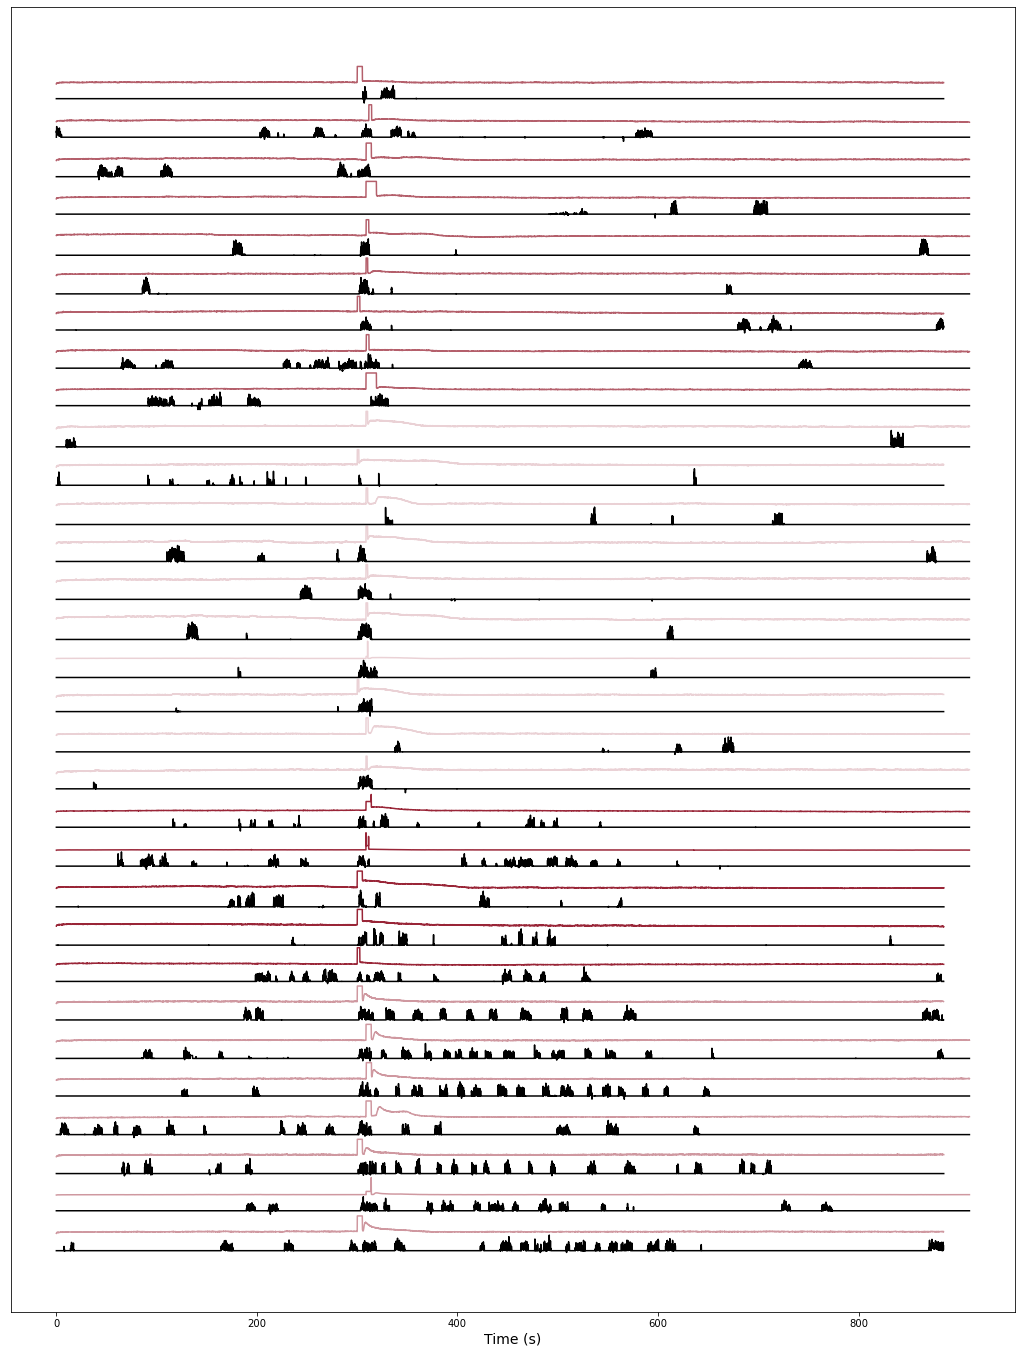

In [21]:
plotNikLoco("chr2_sd")

In [19]:
def compareLoco(exp_type):
    AMPLITUDE = 100.0
    offset = 0
    fig = plt.figure(figsize=(18,24))
    mouse_ids = traces_dict.keys()
    prev_range = 0.0
    for win_type in exptype_wintype_id_dict[exp_type].keys():
        for mouse_id in exptype_wintype_id_dict[exp_type][win_type].keys():
            for event_uuid in exptype_wintype_id_dict[exp_type][win_type][mouse_id]:
                df_segments = ddoc.getSegmentsForUUID(event_uuid)
                i_frame_stim_begin = df_segments[df_segments["interval_type"] == "stimulation"].frame_begin.iloc[0] - 1
                i_frame_stim_end = df_segments[df_segments["interval_type"] == "stimulation"].frame_end.iloc[0] - 1  # in 1 indexing, inclusive

                lfp_mov_trace = traces_dict[event_uuid]["lfp_mov_y"]
                t_lfp = traces_dict[event_uuid]["lfp_mov_t"]
                lfp_min = min(lfp_mov_trace)
                lfp_max = max(lfp_mov_trace)
                

                t = traces_dict[event_uuid]["lv_t_s"]



                labview_trace = traces_dict[event_uuid]["lv_speed"]
                min_lv = min(labview_trace[10:])
                max_lv = max(labview_trace[10:])
                plt.plot(t_lfp, AMPLITUDE*(lfp_mov_trace - lfp_min)/(lfp_max - lfp_min)+offset, color="black")
                offset +=1.1*AMPLITUDE

                if t[0] +1000 < t_lfp[0]:
                    print(f"{event_uuid} {mouse_id}")
                    
                
                color = df_colors[df_colors["mouse_id"] == mouse_id].color.iloc[0]
                plt.plot(t, AMPLITUDE*(labview_trace- min_lv)/(max_lv - min_lv)+offset, color=color)
                offset+=1.1*AMPLITUDE





                if (len(traces_dict[event_uuid]["mean_fluo"]) != 13483):
                    print(f'{event_uuid}: {len(traces_dict[event_uuid]["mean_fluo"])}, {mouse_id}, {exp_type}')





    #plt.axis("off")
    plt.yticks([])
    plt.xlabel("Time (s)", fontsize=14)
    #plt.xlim((300, 460))  # 250, 500
    if save_figs:
        out_fpath = f"D:\\Downloads\\traces_normalized_{get_datetime_for_fname()}{file_format}"
        plt.savefig(out_fpath,bbox_inches='tight', dpi=300)
        print(f"Saved as {out_fpath}")
    plt.show()

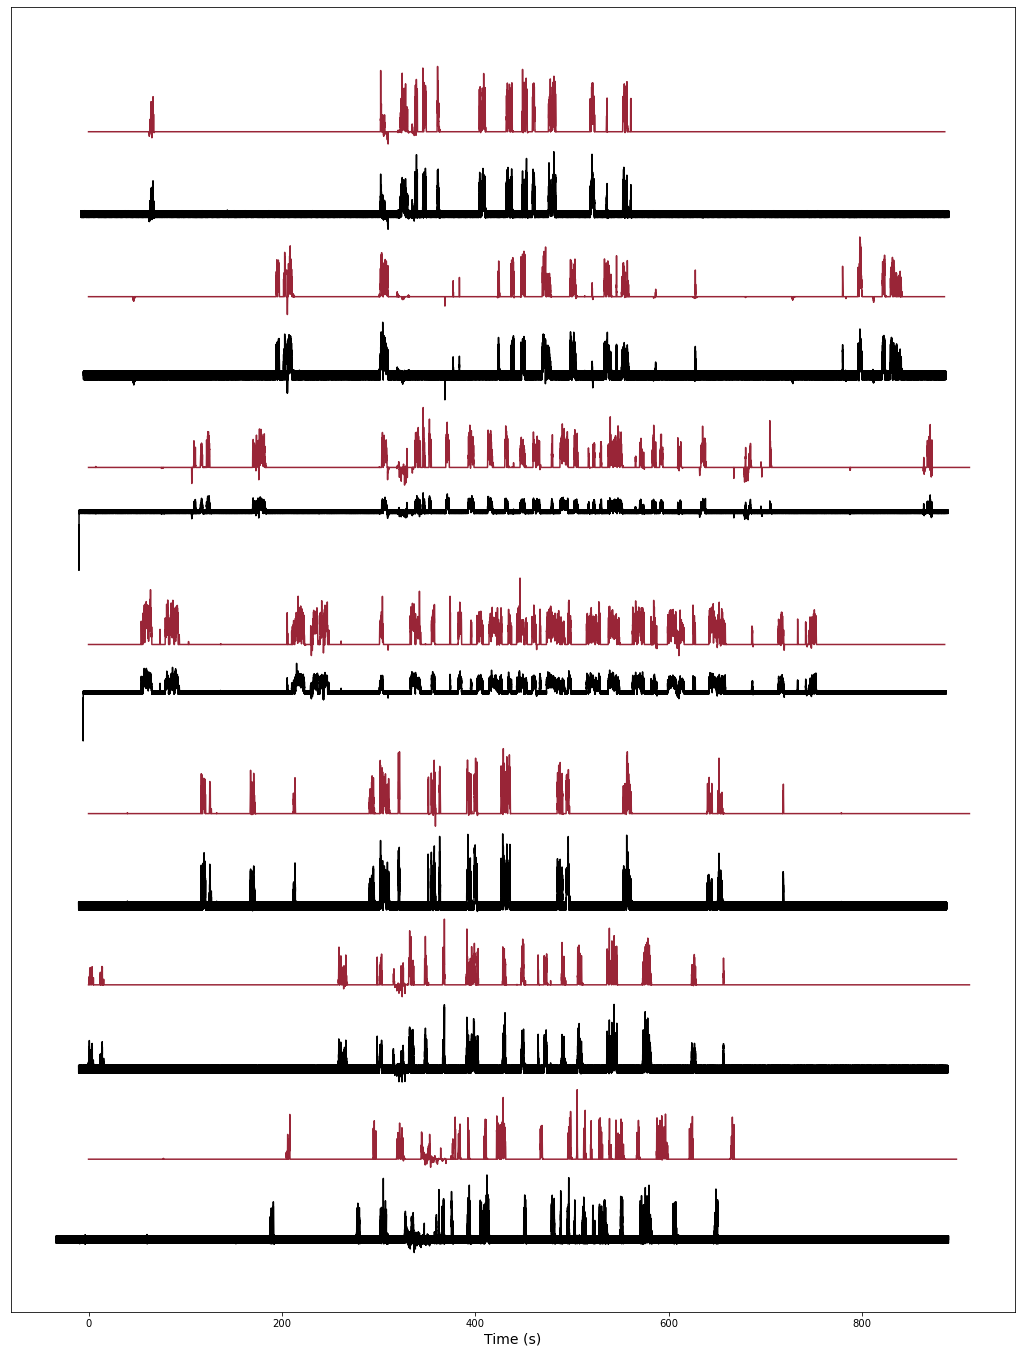

In [20]:
compareLoco("chr2_szsd")